## Damped Harmonic Oscillator

- Subject: Physics-informed Neural Networks
- Reference:
  - https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/
  - https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb

### Problem

Solve an inital value problem:

$$m\frac{d^2u}{dt^2} + \mu\frac{du}{dt} + k u =0,\quad u(0)=1,\quad \frac{du}{dt}(0) = 0,\quad t\in[0, 1]$$

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

In [39]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loss Functions and Data

In [40]:
## Equation parameters:
d, w0 = 2, 20       ## reference value w0 = 20
mu, k = 2*d, w0**2

def u_exact(t, d=d, w0=w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A*np.cos(phi + w*t)*np.exp(-d*t)

In [41]:
def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True, retain_graph=True)[0]
    residual = u_tt + mu*u_t + k*u
    return torch.mean(residual**2)

def ic_du_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    return torch.mean((u_t[0] - 0)**2)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 1, 101)
t = torch.tensor(t_np).float().view(-1, 1).to(device)

## Initial points: initial condition loss
t0 = torch.tensor(0).float().view(-1, 1).to(device)
u0 = torch.tensor(1).float().view(-1, 1).to(device)

### Modeling and Training

In [42]:
## Model
model = nn.Sequential(
    nn.Linear(1, 50),  nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 1),
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training
n_epochs = 10000
model.train()
for epoch in range(1, n_epochs + 1):
    loss_res = residual_loss(model, t)                  ## residaul loss
    loss_du_ic = ic_du_loss(model, t)                   ## initial condition loss
    loss_u_ic = torch.mean((model(t0) - u0)**2)         ## initial condition loss

    total_loss = loss_res + loss_du_ic + loss_u_ic

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch[{epoch}/{n_epochs}] total: {total_loss.item():.2e} "
              f"res: {loss_res.item():.2e} ic_du: {loss_du_ic.item():.2e} "
              f"ic_u: {loss_u_ic.item():.2e}")

Epoch[1000/10000] total: 1.00e+00 res: 2.55e-03 ic_du: 1.21e-05 ic_u: 1.00e+00
Epoch[2000/10000] total: 3.60e+00 res: 2.61e+00 ic_du: 1.54e-06 ic_u: 9.92e-01
Epoch[3000/10000] total: 1.01e+00 res: 1.17e-02 ic_du: 7.18e-09 ic_u: 9.99e-01
Epoch[4000/10000] total: 1.00e+00 res: 1.85e-04 ic_du: 1.37e-09 ic_u: 1.00e+00
Epoch[5000/10000] total: 1.00e+00 res: 1.14e-04 ic_du: 2.86e-07 ic_u: 1.00e+00
Epoch[6000/10000] total: 1.00e+00 res: 9.37e-05 ic_du: 7.93e-07 ic_u: 1.00e+00
Epoch[7000/10000] total: 1.00e+00 res: 9.85e-05 ic_du: 1.28e-06 ic_u: 1.00e+00
Epoch[8000/10000] total: 1.00e+00 res: 9.69e-05 ic_du: 1.32e-06 ic_u: 1.00e+00
Epoch[9000/10000] total: 1.06e+00 res: 5.76e-02 ic_du: 2.79e-05 ic_u: 9.99e-01
Epoch[10000/10000] total: 1.00e+00 res: 7.50e-05 ic_du: 7.01e-07 ic_u: 1.00e+00


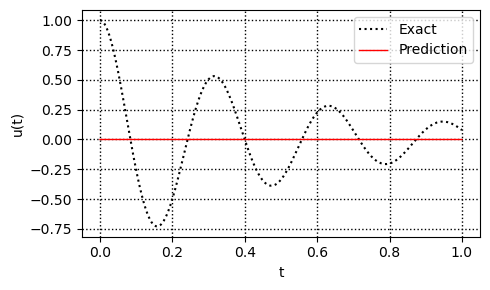

In [43]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()

### Modeling and Training with Loss Weights

In [44]:
## Model
model = nn.Sequential(
    nn.Linear(1, 50),  nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 1),
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training
n_epochs = 10000
model.train()
for epoch in range(1, n_epochs + 1):
    loss_res = residual_loss(model, t)                  ## residaul loss
    loss_du_ic = ic_du_loss(model, t)                   ## initial condition loss
    loss_u_ic = torch.mean((model(t0) - u0)**2)         ## initial condition loss

    total_loss = loss_res * 1e-4 + loss_du_ic * 1e-2 + loss_u_ic

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch[{epoch}/{n_epochs}] total: {total_loss.item():.2e} "
              f"res: {loss_res.item():.2e} ic_du: {loss_du_ic.item():.2e} "
              f"ic_u: {loss_u_ic.item():.2e}")

Epoch[1000/10000] total: 3.03e-02 res: 2.92e+02 ic_du: 3.95e-06 ic_u: 1.09e-03
Epoch[2000/10000] total: 1.18e-02 res: 1.16e+02 ic_du: 1.34e-05 ic_u: 1.92e-04
Epoch[3000/10000] total: 9.42e-03 res: 9.32e+01 ic_du: 3.09e-05 ic_u: 1.01e-04
Epoch[4000/10000] total: 8.36e-03 res: 8.27e+01 ic_du: 4.31e-07 ic_u: 8.05e-05
Epoch[5000/10000] total: 6.40e-03 res: 6.31e+01 ic_du: 8.40e-04 ic_u: 8.34e-05
Epoch[6000/10000] total: 7.40e-03 res: 6.79e+01 ic_du: 5.25e-02 ic_u: 8.22e-05
Epoch[7000/10000] total: 5.24e-04 res: 5.18e+00 ic_du: 5.28e-04 ic_u: 7.17e-07
Epoch[8000/10000] total: 3.55e-04 res: 3.54e+00 ic_du: 2.07e-06 ic_u: 8.76e-07
Epoch[9000/10000] total: 2.71e-04 res: 2.70e+00 ic_du: 1.43e-05 ic_u: 2.33e-07
Epoch[10000/10000] total: 2.09e-04 res: 2.09e+00 ic_du: 3.86e-08 ic_u: 3.95e-07


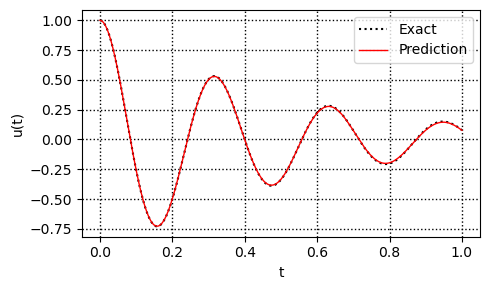

In [45]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()

### Modeling and Training with Loss Weights

In [46]:
n_data = 50
t_data_np = np.linspace(0, 0.2, n_data) + np.random.randn(n_data)*0.01
u_data_np = u_exact(t_data_np) + np.random.randn(n_data)*0.01
t_data = torch.tensor(t_data_np).float().view(-1, 1).to(device)
u_data = torch.tensor(u_data_np).float().view(-1, 1).to(device)

## Model
model = nn.Sequential(
    nn.Linear(1, 50),  nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 50), nn.Tanh(),
    nn.Linear(50, 1),
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training
n_epochs = 10000
model.train()
for epoch in range(1, n_epochs + 1):
    loss_res = residual_loss(model, t)                  ## residaul loss
    loss_du_ic = ic_du_loss(model, t)                   ## initial condition loss
    loss_u_ic = torch.mean((model(t0) - u0)**2)         ## initial condition loss
    loss_data = torch.mean((model(t_data) - u_data)**2) ## data loss

    total_loss = loss_res * 1e-4 + loss_du_ic * 1e-2 + loss_u_ic + loss_data

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch[{epoch}/{n_epochs}] total: {total_loss.item():.2e} "
              f"res: {loss_res.item():.2e} ic_du: {loss_du_ic.item():.2e} "
              f"ic_u: {loss_u_ic.item():.2e} data: {loss_data.item():.2e}")

Epoch[1000/10000] total: 4.53e-02 res: 4.21e+02 ic_du: 5.96e-04 ic_u: 9.86e-04 data: 2.18e-03
Epoch[2000/10000] total: 3.00e-02 res: 2.85e+02 ic_du: 4.19e-03 ic_u: 9.71e-04 data: 5.17e-04
Epoch[3000/10000] total: 1.36e-02 res: 1.32e+02 ic_du: 9.12e-08 ic_u: 7.51e-05 data: 2.68e-04
Epoch[4000/10000] total: 1.18e-02 res: 1.15e+02 ic_du: 5.90e-08 ic_u: 3.83e-05 data: 2.23e-04
Epoch[5000/10000] total: 1.01e-02 res: 9.93e+01 ic_du: 6.95e-07 ic_u: 2.78e-05 data: 1.87e-04
Epoch[6000/10000] total: 1.70e-02 res: 1.44e+02 ic_du: 1.61e-03 ic_u: 1.58e-03 data: 1.06e-03
Epoch[7000/10000] total: 1.00e-02 res: 8.93e+01 ic_du: 1.90e-04 ic_u: 6.48e-04 data: 4.27e-04
Epoch[8000/10000] total: 4.12e-03 res: 4.00e+01 ic_du: 4.50e-08 ic_u: 8.68e-06 data: 1.11e-04
Epoch[9000/10000] total: 1.59e-03 res: 1.50e+01 ic_du: 9.56e-08 ic_u: 2.44e-06 data: 8.79e-05
Epoch[10000/10000] total: 8.14e-04 res: 7.34e+00 ic_du: 1.14e-07 ic_u: 3.96e-07 data: 7.96e-05


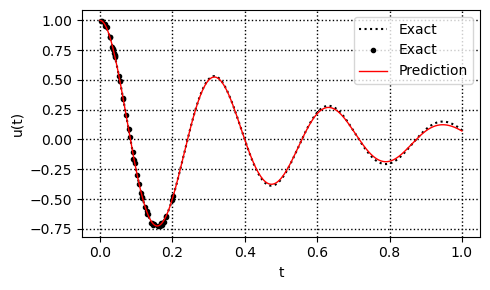

In [47]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_data_np, u_data_np, 'ko', ms=3, label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()